In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *



25.0%. Run time:   1.83s. Est. time left: 00:00:00:05
50.0%. Run time:   3.66s. Est. time left: 00:00:00:03
75.0%. Run time:   5.34s. Est. time left: 00:00:00:01
100.0%. Run time:   7.04s. Est. time left: 00:00:00:00
Total run time:   7.04s
$n = $1.0,  $ \Delta_q =$12.0,  $\chi =$1.0,   $\kappa =$4.3,   all normed by $2 \pi Mhz.$$ Fidelity =$0.994,   trace dist =0.045.


/home/saha/miniconda3/lib/python3.12/site-packages/qutip/core/qobj.py:1623: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


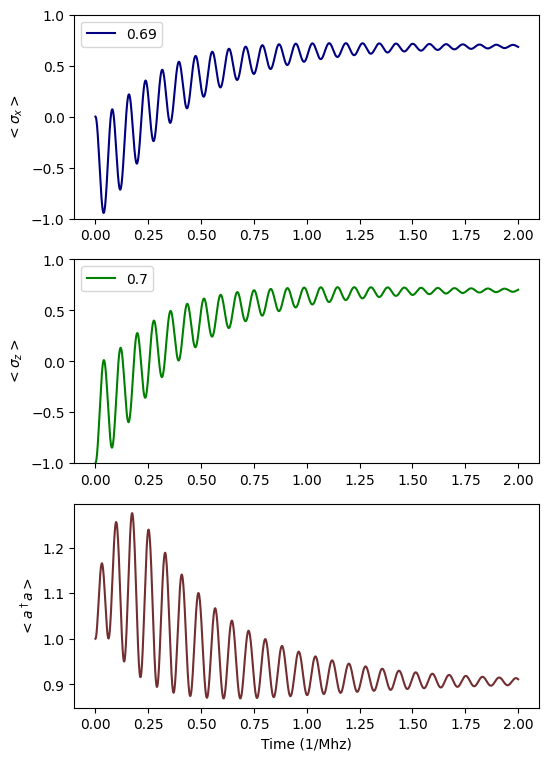

In [3]:
N = 20

cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
cavity_photon_number = 10**(input_power/10)
rabi_freq = 2*np.pi*9*10**6
eff_coupling = 2*np.pi*(1)*10**6
qubit_targetz = 9*2*np.pi*10**6
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 

qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5

cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

norm = 2*np.pi*10**6
final_time = 2 # in 1/Mhz
tlist = np.linspace(0, final_time, 10000)/(10**6)

tlist__N = tlist*norm
cavity_detuning__N = cavity_detuning/norm
cavity_drive_amplitude__N = cavity_drive_amplitude/norm
qubit_detuning__N = qubit_detuning/norm
eff_coupling__N = eff_coupling/norm
rabi_freq__N = rabi_freq/norm
cavity_diss_rate__N = cavity_diss_rate/norm

#Create operators.
d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam())    

#Put the Hamiltonian together from its different parts.
H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
H_qubit = -.5*(qubit_detuning__N - eff_coupling__N)*sz - .5*rabi_freq__N*sx
H_int =   eff_coupling__N*d.dag()*d*sz
H = H_cav + H_qubit + H_int

psi0_atom = basis(2,1)
psi0_cavity = coherent(N,cavity_field)
initial_state = tensor(psi0_cavity, psi0_atom)

prog = {"chunk_size": 25} 
opt = {
    "nsteps": 1000000, 
    "progress_bar": "text",
    "max_step": 0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                            rabi_freq__N, eff_coupling__N, cavity_diss_rate__N]),
    "progress_kwargs": prog,
    "method": "dop853"
    }

tevol = mesolve(H, initial_state, tlist__N, 
                [np.sqrt(cavity_diss_rate__N) * d], options=opt)  


#Get qubit final state from the dynamics.
qubit_ss = tevol.states[-1].ptrace(1) 

#Compare with   target state.
ground_state = H_qubit.groundstate()[1].ptrace(1)
target_state = ground_state * ground_state.dag()

fidel = fidelity(qubit_ss, target_state)
tr_dist = tracedist(qubit_ss, target_state)

parameters = {"N":N,
                "final_time": final_time,
                "tlist": tlist,
                "input_power": input_power,
                "cavity_detuning": cavity_detuning,
                "rabi_freq": rabi_freq,
                "cavity_diss_rate": cavity_diss_rate,
                "norm": norm,
                "initial_state": initial_state,
                "fidelity": fidel,
                "trace_distance": tr_dist} 

x = expect(sx, tevol.states)
z = expect(sz, tevol.states)
ph_number = expect(d.dag()*d, tevol.states)

fig_title = r'$n = $' + f'{cavity_photon_number},  ' + \
        r'$ \Delta_q =$' + f'{round(qubit_detuning__N,3)},  ' + \
        r'$\chi =$' + f'{round(eff_coupling__N,3)},   ' + \
        r'$\kappa =$' + f'{round(cavity_diss_rate__N,3)},  ' + \
        ' all normed by ' + r'$2 \pi Mhz.$' + \
        r'$ Fidelity =$' + f'{round(fidel,3)},   ' + \
        r'trace dist =' + f'{round(tr_dist,3)}.   ' 

xmean = np.mean(x[-20:])
zmean = np.mean(z[-20:])

#Create the figures.
fig, axes = plt.subplots(3, 1, figsize=(6,9))

#fig.suptitle(fig_title)

axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(xmean,2)}")
#axes[0].set_xlabel('Time (1/Mhz)')
axes[0].set_ylabel(r'$ <\sigma_x >$')
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(zmean,2)}")
#axes[1].set_xlabel('Time (1/Mhz)')
axes[1].set_ylabel(r'$<\sigma_z >$')
axes[1].legend()
axes[1].set_ylim(-1, 1)

axes[2].plot(tlist*10**6, ph_number, color='#722E30')
axes[2].set_xlabel('Time (1/Mhz)')
axes[2].set_ylabel(r'$<a^\dagger a>$')

print(  r'$n = $' + f'{cavity_photon_number},  ' + \
        r'$ \Delta_q =$' + f'{round(qubit_detuning__N,3)},  ' + \
        r'$\chi =$' + f'{round(eff_coupling__N,3)},   ' + \
        r'$\kappa =$' + f'{round(cavity_diss_rate__N,3)},  ' + \
        ' all normed by ' + r'$2 \pi Mhz.$' + \
        r'$ Fidelity =$' + f'{round(fidel,3)},   ' + \
        r'trace dist =' + f'{round(tr_dist,3)}.' )